# Importing libraries

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix, precision_score, recall_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score

# Loading train and test data

In [2]:
msg_train = pd.read_csv('train.csv')
msg_train

,label,message,length
0,1,"['free2day', 'sexy', 'st', 'george', ""'s"", 'da...",26
1,0,"['armand', 'say', 'get', 'as', 'epsilon']",5
2,0,"['lol', 'i', ""'m"", 'hot', 'air', 'balloon', '!']",7
3,0,"['you', 'know', ',', 'wot', 'people', 'wear', ...",21
4,0,"['good', 'morning', ',', 'love', '...', 'i', '...",27
...,...,...,...
4454,0,"['hi', ',', 'wlcome', 'back', ',', 'wonder', '...",13
4455,1,"['ree', 'entry', '2', 'weekly', 'comp', 'chanc...",27
4456,0,"['``', 'oh', 'fuck', '.', 'juswoke', 'up', 'in...",31
4457,0,"['not', 'much', 'no', 'fights', '.', 'it', 'wa...",12


In [3]:
msg_test = pd.read_csv('test.csv')
msg_test

,label,message,length
0,0,"['you', 'still', 'coming', 'tonight', '?']",5
1,0,"['``', 'hey', 'babe', '!', 'far', '2', 'spun-o...",46
2,0,"['ya', 'even', 'cooky', 'jelly']",4
3,0,"['sorry', ""'ve"", 'gone', 'place', '.', 'i.ll',...",11
4,0,"['when', 'going', 'ride', 'bike', '?']",5
...,...,...,...
1110,0,"['my', 'supervisor', 'find', '4', 'one', 'lor'...",19
1111,1,"['bored', 'housewife', '!', 'chat', 'n', 'date...",14
1112,0,"['rose', 'red', ',', 'red', 'blood', ',', 'blo...",59
1113,0,"['also', 'remember', 'bead', ""n't"", 'come', '....",8


# Model Selection

We choose to use the following three models for spam/ham classification and record their Accuracy, Precision, Recall, F1-score and Area under the Precision-Recall respectively.

1. Naive Bayes
2. Logistic Regression
3. Support Vector Machine

In [4]:
models = ['Naive Bayes', 'Logistic Regression', 'Support Vector Machines']
f1 = []
acc = []
precision = []
recall = []
pr_auc = []

# 1. Naive Bayes Classifier

In [5]:
MultinomialNB().get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True, 'force_alpha': True}

## Creating pipeline

In [6]:
pipeline_nb = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

## Cross Validation Scores

In [7]:
scores = cross_val_score(pipeline_nb,  # steps to convert raw messages into models
                         msg_train['message'],  # training data
                         msg_train['label'],  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='accuracy',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
scores

array([0.96412556, 0.97982063, 0.96412556, 0.97757848, 0.96636771,
       0.97533632, 0.9529148 , 0.97982063, 0.96412556, 0.9505618 ])

In [8]:
param_grid = {
    'classifier__alpha': [0.1, 0.5, 1],
}

LR_Classifier = GridSearchCV(pipeline_nb, param_grid, cv=5, scoring='f1', verbose=3)
LR_Classifier.fit(msg_train['message'], msg_train['label'])

print("Best parameters:", LR_Classifier.best_params_)
print("Best score:", LR_Classifier.best_score_)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV 1/5] END .............classifier__alpha=0.1;, score=0.944 total time=   0.1s
[CV 2/5] END .............classifier__alpha=0.1;, score=0.961 total time=   0.1s
[CV 3/5] END .............classifier__alpha=0.1;, score=0.946 total time=   0.1s
[CV 4/5] END .............classifier__alpha=0.1;, score=0.937 total time=   0.1s
[CV 5/5] END .............classifier__alpha=0.1;, score=0.924 total time=   0.1s
[CV 1/5] END .............classifier__alpha=0.5;, score=0.922 total time=   0.1s
[CV 2/5] END .............classifier__alpha=0.5;, score=0.946 total time=   0.1s
[CV 3/5] END .............classifier__alpha=0.5;, score=0.896 total time=   0.1s
[CV 4/5] END .............classifier__alpha=0.5;, score=0.891 total time=   0.1s
[CV 5/5] END .............classifier__alpha=0.5;, score=0.871 total time=   0.1s
[CV 1/5] END ...............classifier__alpha=1;, score=0.871 total time=   0.1s
[CV 2/5] END ...............classifier__alpha=1;,

In [9]:
scores.mean(), scores.std()

(np.float64(0.9674777044389581), np.float64(0.010008235582897696))

## Fitting the model

In [10]:
pipeline_nb.fit(msg_train['message'],msg_train['label'])

Pipeline(steps=[('bow', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('classifier', MultinomialNB())])

## Performance on Train Data

### Accuracy

In [11]:
predictions = pipeline_nb.predict(msg_train['message'])
accuracy_score(msg_train['label'], predictions)

0.9816102265081857

### Precision

In [12]:
precision_score(msg_train['label'], predictions)

1.0

### Recall

In [13]:
recall_score(msg_train['label'], predictions)

0.8600682593856656

### F1 Score

In [14]:
f1_score(msg_train['label'], predictions, pos_label=1)

0.9247706422018349

### Precision-Recall Curve

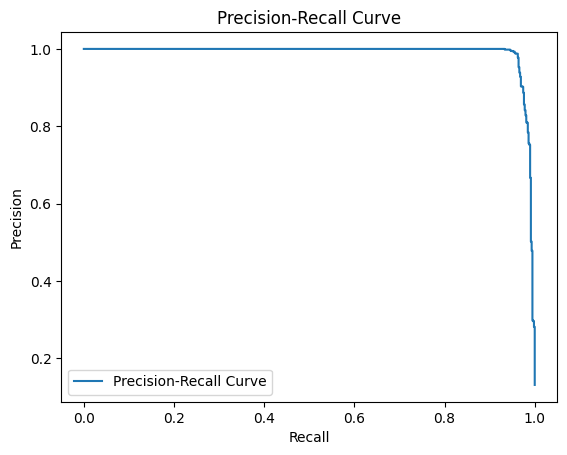

In [15]:
p, r, t = precision_recall_curve(msg_train['label'], pipeline_nb.predict_proba(msg_train['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [16]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9902015164608517


### Confusion Matrix

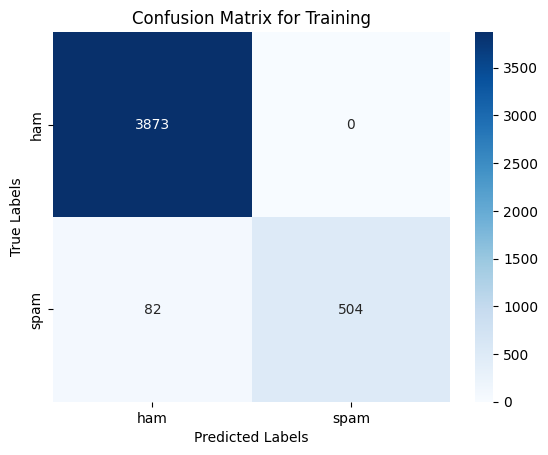

In [17]:
cm = confusion_matrix(msg_train['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Train Data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [18]:
print(classification_report(msg_train['label'], predictions))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3873
           1       1.00      0.86      0.92       586

    accuracy                           0.98      4459
   macro avg       0.99      0.93      0.96      4459
weighted avg       0.98      0.98      0.98      4459



## Performance on Test Data

### Accuracy

In [19]:
predictions = pipeline_nb.predict(msg_test['message'])
accuracy = accuracy_score(msg_test['label'], predictions)
accuracy

0.9713004484304932

In [20]:
acc.append(accuracy)

### Precision

In [21]:
p = precision_score(msg_test['label'], predictions)
p

1.0

In [22]:
precision.append(p)

### Recall

In [23]:
r = recall_score(msg_test['label'], predictions)
r

0.8012422360248447

In [24]:
recall.append(r)

### F1 Score

In [25]:
f = f1_score(msg_test['label'], predictions, pos_label=1)
f

0.8896551724137931

In [26]:
f1.append(f)

### Precision-Recall Curve

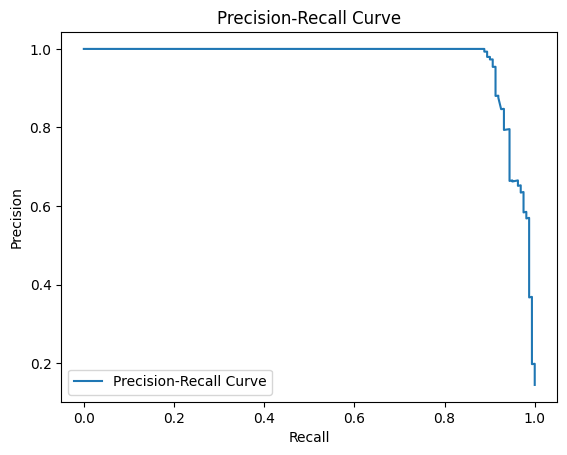

In [27]:
p, r, t = precision_recall_curve(msg_test['label'], pipeline_nb.predict_proba(msg_test['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [28]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9694212512987846


In [29]:
pr_auc.append(auc_pr)

### Confusion Matrix

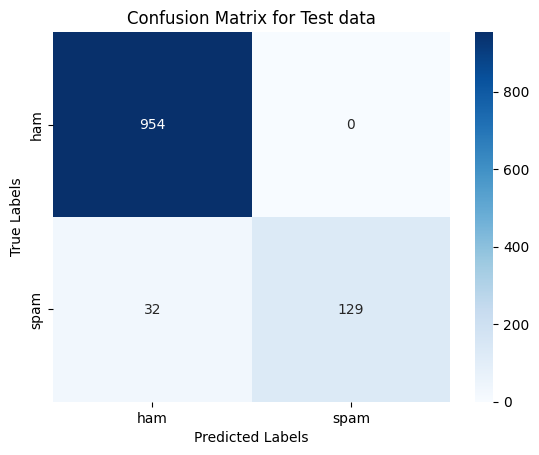

In [30]:
cm = confusion_matrix(msg_test['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [31]:
print(classification_report(msg_test['label'], predictions))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       954
           1       1.00      0.80      0.89       161

    accuracy                           0.97      1115
   macro avg       0.98      0.90      0.94      1115
weighted avg       0.97      0.97      0.97      1115



# 2. Logistic Regression

In [32]:
LogisticRegression().get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'deprecated',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

## Creating Pipeline

In [33]:
pipeline_LR = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', LogisticRegression(random_state=42, solver='liblinear', max_iter=5000))  # train on TF-IDF vectors w/ logistic regression
])

In [34]:
scores = cross_val_score(pipeline_LR,  # steps to convert raw messages into models
                         msg_train['message'],  # training data
                         msg_train['label'],  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='f1',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
scores

array([0.82352941, 0.91891892, 0.85436893, 0.91891892, 0.85436893,
       0.87619048, 0.75268817, 0.87619048, 0.85148515, 0.75789474])

In [35]:
scores.mean(), scores.std()

(np.float64(0.8484554123461134), np.float64(0.054352280126538165))

## Fitting the model

In [36]:
param_grid = {
    'classifier__C': [0.1, 1, 10, 100],
    'classifier__penalty': ['l2','l1'],
    'classifier__class_weight': [None, 'balanced']
}

LR_Classifier = GridSearchCV(pipeline_LR, param_grid, cv=5, scoring='f1_micro', verbose=3)
LR_Classifier.fit(msg_train['message'], msg_train['label'])

print("Best parameters:", LR_Classifier.best_params_)
print("Best score:", LR_Classifier.best_score_)

Fitting 5 folds for each of 16 candidates, totalling 80 fits
[CV 1/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2;, score=0.868 total time=   0.1s
[CV 2/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2;, score=0.869 total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2;, score=0.869 total time=   0.1s
[CV 4/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2;, score=0.869 total time=   0.1s
[CV 5/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l2;, score=0.869 total time=   0.1s
[CV 1/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1;, score=0.865 total time=   0.1s
[CV 2/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1;, score=0.869 total time=   0.0s
[CV 3/5] END classifier__C=0.1, classifier__class_weight=None, classifier__penalty=l1;, score=0.868 total 

/home/utpalraj/coursework/AML/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__class_weight=None, classifier__penalty=l1;, score=0.991 total time=   2.2s
[CV 3/5] END classifier__C=10, classifier__class_weight=None, classifier__penalty=l1;, score=0.971 total time=   0.1s


/home/utpalraj/coursework/AML/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__class_weight=None, classifier__penalty=l1;, score=0.980 total time=   7.2s


/home/utpalraj/coursework/AML/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 5/5] END classifier__C=10, classifier__class_weight=None, classifier__penalty=l1;, score=0.980 total time=   1.4s
[CV 1/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2;, score=0.990 total time=   0.0s
[CV 2/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2;, score=0.988 total time=   0.0s
[CV 3/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2;, score=0.982 total time=   0.0s
[CV 4/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2;, score=0.988 total time=   0.0s
[CV 5/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l2;, score=0.982 total time=   0.0s
[CV 1/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1;, score=0.976 total time=   0.0s


/home/utpalraj/coursework/AML/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1;, score=0.987 total time=   7.2s
[CV 3/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1;, score=0.970 total time=   0.1s


/home/utpalraj/coursework/AML/lib/python3.12/site-packages/sklearn/svm/_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 4/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1;, score=0.984 total time=  12.8s
[CV 5/5] END classifier__C=10, classifier__class_weight=balanced, classifier__penalty=l1;, score=0.980 total time=   0.0s
[CV 1/5] END classifier__C=100, classifier__class_weight=None, classifier__penalty=l2;, score=0.991 total time=   0.0s
[CV 2/5] END classifier__C=100, classifier__class_weight=None, classifier__penalty=l2;, score=0.992 total time=   0.0s
[CV 3/5] END classifier__C=100, classifier__class_weight=None, classifier__penalty=l2;, score=0.984 total time=   0.0s
[CV 4/5] END classifier__C=100, classifier__class_weight=None, classifier__penalty=l2;, score=0.983 total time=   0.0s
[CV 5/5] END classifier__C=100, classifier__class_weight=None, classifier__penalty=l2;, score=0.985 total time=   0.0s
[CV 1/5] END classifier__C=100, classifier__class_weight=None, classifier__penalty=l1;, score=0.981 total time=   0.0s
[CV 2/5] END classifier__C=100, classifier

## Performance on Train Data

### Accuracy

In [37]:
predictions = LR_Classifier.predict(msg_train['message'])
accuracy_score(msg_train['label'],predictions)

1.0

### Precision

In [38]:
precision_score(msg_train['label'], predictions)

1.0

### Recall

In [39]:
recall_score(msg_train['label'], predictions)

1.0

### F1 Score

In [40]:
f1_score(msg_train['label'], predictions, pos_label=1)

1.0

### Precision-Recall Curve

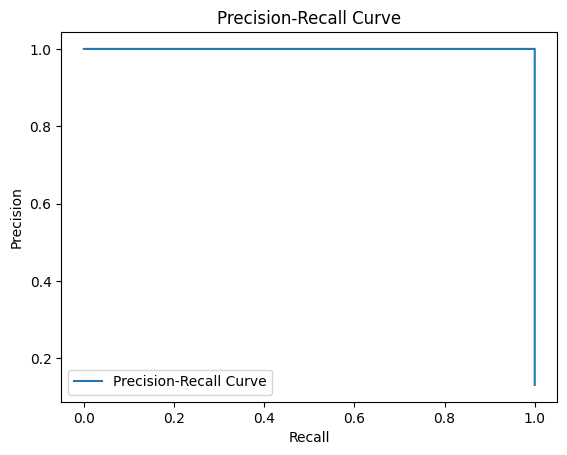

In [41]:
p, r, t = precision_recall_curve(msg_train['label'], LR_Classifier.predict_proba(msg_train['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [42]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 1.0


### Confusion Matrix

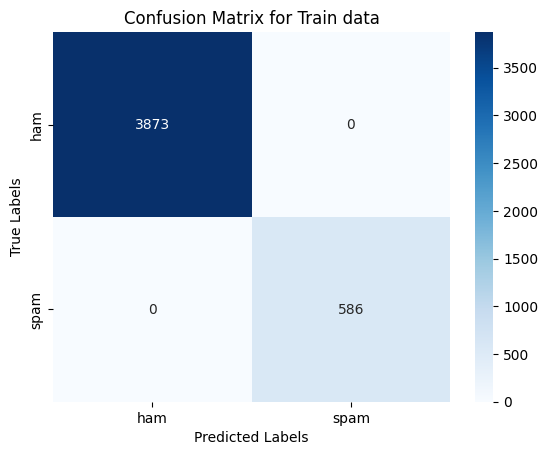

In [43]:
cm = confusion_matrix(msg_train['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Train data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [44]:
print(classification_report(msg_train['label'],predictions,digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3873
           1     1.0000    1.0000    1.0000       586

    accuracy                         1.0000      4459
   macro avg     1.0000    1.0000    1.0000      4459
weighted avg     1.0000    1.0000    1.0000      4459



## Performance on Test Data

### Accuracy

In [45]:
predictions = LR_Classifier.predict(msg_test['message'])
accuracy = accuracy_score(msg_test['label'], predictions)
accuracy

0.9865470852017937

In [46]:
acc.append(accuracy)

### Precision

In [47]:
p = precision_score(msg_test['label'], predictions)
p

0.967948717948718

In [48]:
precision.append(p)

### Recall

In [49]:
r = recall_score(msg_test['label'], predictions)
r

0.937888198757764

In [50]:
recall.append(r)

### F1 Score

In [51]:
f = f1_score(msg_test['label'], predictions, pos_label=1)
f

0.9526813880126183

In [52]:
f1.append(f)

### Precision-Recall Curve

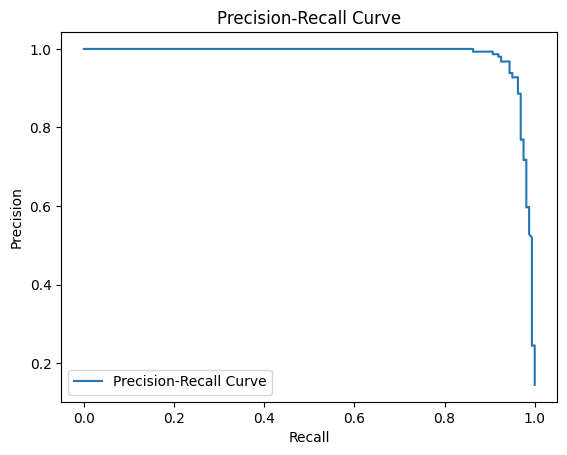

In [53]:
p, r, t = precision_recall_curve(msg_test['label'], LR_Classifier.predict_proba(msg_test['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [54]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9834777340385062


In [55]:
pr_auc.append(auc_pr)

### Confusion Matrix

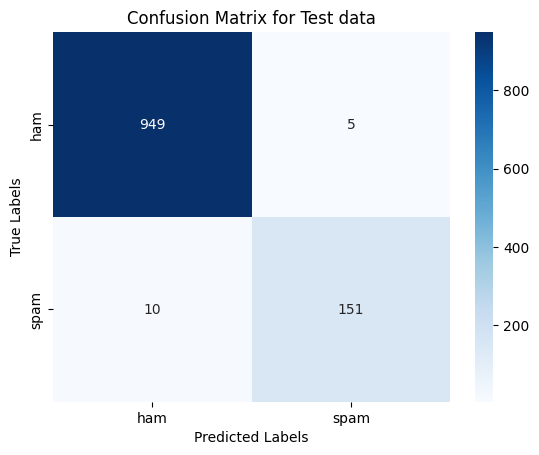

In [56]:
cm = confusion_matrix(msg_test['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [57]:
print(classification_report(msg_test['label'], predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9896    0.9948    0.9922       954
           1     0.9679    0.9379    0.9527       161

    accuracy                         0.9865      1115
   macro avg     0.9788    0.9663    0.9724      1115
weighted avg     0.9865    0.9865    0.9865      1115



# 3. Support Vector Machines

In [58]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [59]:
pipeline_svm = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', SVC(probability=True, random_state=42))  # train on TF-IDF vectors w/ SVM classifier
])

In [60]:
scores = cross_val_score(pipeline_svm,  # steps to convert raw messages into models
                         msg_train['message'],  # training data
                         msg_train['label'],  # training labels
                         cv=10,  # split data randomly into 10 parts: 9 for training, 1 for scoring
                         scoring='f1',  # which scoring metric?
                         n_jobs=-1,  # -1 = use all cores = faster
                         )
scores

array([0.9380531 , 0.96491228, 0.92727273, 0.97391304, 0.90740741,
       0.91743119, 0.85148515, 0.95495495, 0.92592593, 0.90566038])

In [61]:
scores.mean(), scores.std()

(np.float64(0.9267016155620056), np.float64(0.03342972760001904))

## Fitting the model

In [62]:
param_grid = {
    'classifier__C': [1, 5, 10],
    'classifier__kernel': ['linear', 'rbf', 'poly'],
    'classifier__gamma': ['scale', 'auto']
}

svm_classifier = GridSearchCV(pipeline_svm, param_grid, cv=3, scoring='f1_micro',verbose=3)
svm_classifier.fit(msg_train['message'], msg_train['label'])

print("Best parameters:", svm_classifier.best_params_)
print("Best score:", svm_classifier.best_score_)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV 1/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=linear;, score=0.989 total time=   2.1s
[CV 2/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=linear;, score=0.983 total time=   1.6s
[CV 3/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=linear;, score=0.987 total time=   1.6s
[CV 1/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf;, score=0.985 total time=   4.3s
[CV 2/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf;, score=0.976 total time=   4.1s
[CV 3/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=rbf;, score=0.979 total time=   3.5s
[CV 1/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=poly;, score=0.929 total time=   3.6s
[CV 2/3] END classifier__C=1, classifier__gamma=scale, classifier__kernel=poly;, score=0.928 total time=   4.3s
[CV 3/3] END classifier__C=1, classifier

## Performance on Train Data

### Accuracy

In [63]:
predictions = svm_classifier.predict(msg_train['message'])
accuracy_score(msg_train['label'], predictions)

1.0

### Precision

In [64]:
precision_score(msg_train['label'], predictions)

1.0

### Recall

In [65]:
recall_score(msg_train['label'], predictions)

1.0

### F1 Score

In [66]:
f1_score(msg_train['label'], predictions, pos_label=1)

1.0

### Precision-Recall Curve

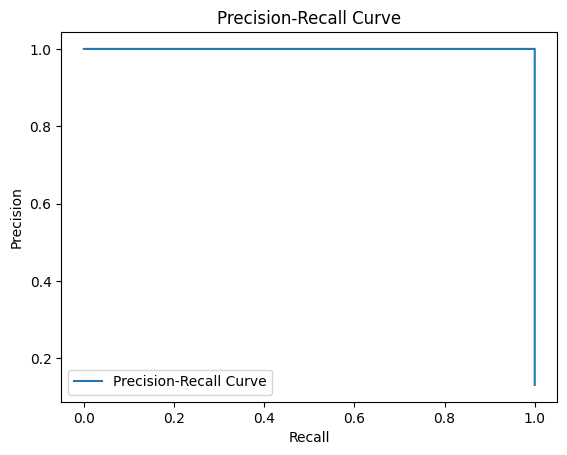

In [67]:
p, r, t = precision_recall_curve(msg_train['label'], svm_classifier.predict_proba(msg_train['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [68]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 1.0


### Confusion Matrix

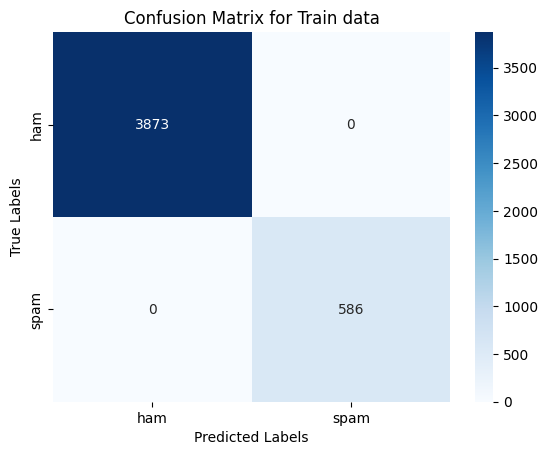

In [69]:
cm = confusion_matrix(msg_train['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Train data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [70]:
print(classification_report(msg_train['label'], predictions, digits=4))

              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000      3873
           1     1.0000    1.0000    1.0000       586

    accuracy                         1.0000      4459
   macro avg     1.0000    1.0000    1.0000      4459
weighted avg     1.0000    1.0000    1.0000      4459



## Performance on Test Data

### Accuracy

In [71]:
predictions = svm_classifier.predict(msg_test['message'])
accuracy = accuracy_score(msg_test['label'], predictions)
accuracy

0.9865470852017937

In [72]:
acc.append(accuracy)

### Precision

In [73]:
p = precision_score(msg_test['label'], predictions)
p

0.9802631578947368

In [74]:
precision.append(p)

### Recall

In [75]:
r = recall_score(msg_test['label'], predictions)
r

0.9254658385093167

In [76]:
recall.append(r)

### F1 Score

In [77]:
f = f1_score(msg_test['label'], predictions, pos_label=1)
f

0.952076677316294

In [78]:
f1.append(f)

### Precision-Recall Curve

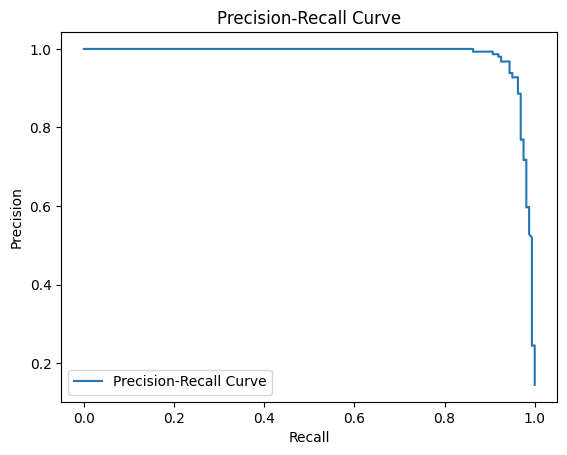

In [79]:
p, r, t = precision_recall_curve(msg_test['label'], LR_Classifier.predict_proba(msg_test['message'])[:,1],pos_label=1)
# plot the curve
plt.plot(r, p, label='Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

In [80]:
auc_pr = auc(r,p)
# print the area under the curve
print('Area under the Precision-Recall Curve:', auc_pr)

Area under the Precision-Recall Curve: 0.9834777340385062


In [81]:
pr_auc.append(auc_pr)

### Confusion Matrix

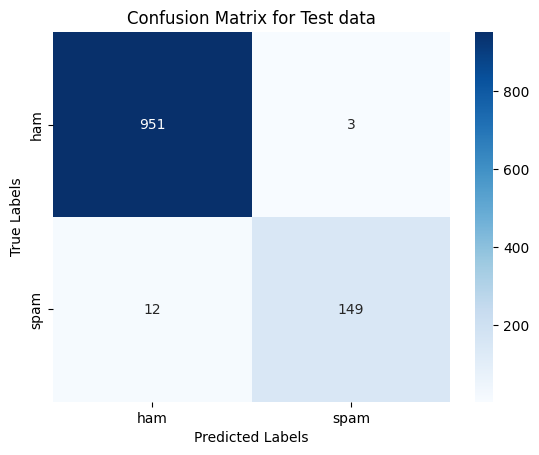

In [82]:
cm = confusion_matrix(msg_test['label'], predictions)
# Plot the confusion matrix
sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=['ham', 'spam'], yticklabels=['ham','spam'])
plt.title('Confusion Matrix for Test data')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

### Classification Report

In [83]:
print(classification_report(msg_test['label'], predictions,digits=4))

              precision    recall  f1-score   support

           0     0.9875    0.9969    0.9922       954
           1     0.9803    0.9255    0.9521       161

    accuracy                         0.9865      1115
   macro avg     0.9839    0.9612    0.9721      1115
weighted avg     0.9865    0.9865    0.9864      1115



# Benchmarking the performance

In [84]:
pd.DataFrame({'Model':models, 'F1 Score':f1, 'Accuracy':acc, 'Precision':precision, 'Recall':recall, 'AUC-PR':pr_auc})

,Model,F1 Score,Accuracy,Precision,Recall,AUC-PR
0,Naive Bayes,0.889655,0.971300,1.000000,0.801242,0.969421
1,Logistic Regression,0.952681,0.986547,0.967949,0.937888,0.983478
2,Support Vector Machines,0.952077,0.986547,0.980263,0.925466,0.983478
